<h1> Coursera Capstone Final Project - The Battle of Neighbourhoods </h1>
<h3> for the IBM Data Science Professional Certificate </h3>

<h2> Description of project </h2>

<p> A family is moving to London and wishes to find schools for kid(s). As a start, the family wishes to find the locations of London which are most convenient and accessible to nearby schools (and to be picky, as many of them as possible). Also, the family wants to explore the neighbo<u>u</u>rhoods suggested (yes, a bit of British spelling).</p>

<p> This project will (i) obtain geographical information about London by parsing a wikipedia page. The names 33 boroughs of London will be used to obtain the corresponding coordinates; (ii) then search nearby schools of these 33 boroughs, specifically elementary schools, middle schools, and high schools using the Foursquare API; (iii) analyse and clean the data; (iv) broadly classify the schools into 4 regions and hence 4 centroids most accessible to nearby schools; and (v) explore the vicinity of the centriods and discover patterns and information. </p>

<h2> Import libraries </h2>

In [1]:
%%capture
#skip the output of library import

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

!pip install geopy
from geopy.geocoders import Nominatim

!pip install folium==0.5.0
import folium

!pip install bs4
from bs4 import BeautifulSoup

<h2> Part 1 - Obtain geolocation data of boroughs of London, UK </h2>

In [2]:
london_boroughs_url = 'https://en.wikipedia.org/wiki/List_of_London_boroughs'
results = requests.get(london_boroughs_url).text
soup = BeautifulSoup(results, 'html.parser')

temp = soup.find_all('table')[0].find_all('tr') # first table of 32 boroughs
temp2 = soup.find_all('table')[1].find_all('tr') # another table of City of London
temp.extend(temp2[1:]) # merge two tables

cols = [temp[0].find_all('th')[i].text.replace('\n','').rstrip() for i in [0,4,6,7]] # obtain useful columns
london_boroughs = pd.DataFrame(columns=cols)

for tr in temp[1:]:
    row = [tr.find_all('td')[i].text.replace('\n','').replace(',','').rstrip() for i in [0,4,6,7]]
    london_boroughs = london_boroughs.append(dict(zip(cols,row)), ignore_index=True)

# clean data
london_boroughs.rename(columns={london_boroughs.columns[3] : 'Population (2019 est)'}, inplace=True)
london_boroughs['Borough'] = london_boroughs['Borough'].apply(lambda x: x.split('[')[0])
london_boroughs['Political control'] = london_boroughs['Political control'].apply(lambda x: x.split('(')[0])
london_boroughs['Area (sq mi)'] = london_boroughs['Area (sq mi)'].astype('float')
london_boroughs['Population (2019 est)'] = london_boroughs['Population (2019 est)'].astype('int')
london_boroughs.at[32, 'Political control'] = None

london_boroughs

Borough Political control  Area (sq mi)  \
0     Barking and Dagenham             Labour         13.93   
1                    Barnet      Conservative         33.49   
2                    Bexley      Conservative         23.38   
3                     Brent            Labour         16.70   
4                   Bromley      Conservative         57.97   
5                    Camden            Labour          8.40   
6                   Croydon            Labour         33.41   
7                    Ealing            Labour         21.44   
8                   Enfield            Labour         31.74   
9                Greenwich             Labour         18.28   
10                  Hackney            Labour          7.36   
11  Hammersmith and Fulham             Labour          6.33   
12                 Haringey            Labour         11.42   
13                   Harrow            Labour         19.49   
14                 Havering     Conservative          43.35   
15               Hillingdon      Conservative         44.67   
16                 Hounslow            Labour         21.61   
17                Islington            Labour          5.74   
18   Kensington and Chelsea      Conservative          4.68   
19     Kingston upon Thames  Liberal Democrat         14.38   
20                  Lambeth            Labour         10.36   
21                 Lewisham            Labour         13.57   
22                   Merton            Labour         14.52   
23                   Newham            Labour         13.98   
24                Redbridge            Labour         21.78   
25     Richmond upon Thames  Liberal Democrat         22.17   
26                Southwark            Labour         11.14   
27                   Sutton  Liberal Democrat         16.93   
28            Tower Hamlets            Labour          7.63   
29           Waltham Forest            Labour         14.99   
30               Wandsworth      Conservative         13.23   
31              Westminster      Conservative          8.29   
32           City of London              None          1.12   

    Population (2019 est)  
0                  212906  
1                  395896  
2                  248287  
3                  329771  
4                  332336  
5                  270029  
6                  386710  
7                  341806  
8                  333794  
9                  287942  
10                 281120  
11                 185143  
12                 268647  
13                 251160  
14                 259552  
15                 306870  
16                 271523  
17                 242467  
18                 156129  
19                 177507  
20                 326034  
21                 305842  
22                 206548  
23                 353134  
24                 305222  
25                 198019  
26                 318830  
27                 206349  
28                 324745  
29                 276983  
30                 329677  
31                 261317  
32                   9721

In [3]:
def getlatlng(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    lct = geolocator.geocode(address+', London, UK')
    lat = lct.latitude
    lng = lct.longitude
    return (lat, lng)

In [4]:
london_boroughs['Coordinates'] = london_boroughs['Borough'].apply(getlatlng)
london_boroughs['Latitude'] = london_boroughs['Coordinates'].apply(lambda x: x[0])
london_boroughs['Longitude'] = london_boroughs['Coordinates'].apply(lambda x: x[1])
london_boroughs.to_csv('London Boroughs.csv', index=False)
london_boroughs.head()

Borough Political control  Area (sq mi)  \
0  Barking and Dagenham             Labour         13.93   
1                 Barnet      Conservative         33.49   
2                 Bexley      Conservative         23.38   
3                  Brent            Labour         16.70   
4                Bromley      Conservative         57.97   

   Population (2019 est)                         Coordinates   Latitude  \
0                 212906   (51.5541171, 0.15050434261994267)  51.554117   
1                 395896              (51.65309, -0.2002261)  51.653090   
2                 248287              (51.4416793, 0.150488)  51.441679   
3                 329771  (51.5639957, -0.27590641378489267)  51.563996   
4                 332336             (51.4028046, 0.0148142)  51.402805   

   Longitude  
0   0.150504  
1  -0.200226  
2   0.150488  
3  -0.275906  
4   0.014814

<h2> Part 2 - Foursquare </h2>

<p> The search query would be based on the category ID. Elementary schools, middle schools, and high schools are of interest </p>

<p> Set up credentials of foursquare.com (output hidden) </p>

In [6]:
CLIENT_ID = 'masked'
CLIENT_SECRET = 'masked'
ACCESS_TOKEN = 'masked'
VERSION = '20210501'

<h3> 2.1 An example to show the data structure </h3>

In [35]:
catids = '4f4533804b9074f6e4fb0105' # Elementary school id
lat, lng = 51.441679, 0.150488 # Bexley
limit = 3 
radius = 3000
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, ACCESS_TOKEN, VERSION, catids, radius, limit)
results = requests.get(url).json()

In [50]:
df_eg = pd.json_normalize(results['response']['venues'])
# Sample output for results
df_eg.loc[0,:]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


id                                                    50993818e4b06f2352348dc5
name                                                   Mayplace Primary School
categories                   [{'id': '4f4533804b9074f6e4fb0105', 'name': 'E...
referralId                                                        v-1620136281
hasPerk                                                                  False
location.address                                                 Woodside Road
location.lat                                                           51.4596
location.lng                                                          0.164196
location.labeledLatLngs      [{'label': 'display', 'lat': 51.45956243180338...
location.distance                                                         2206
location.postalCode                                                    DA7 6EQ
location.cc                                                                 GB
location.city                                       

In [51]:
# Sample output for categories
df_eg.loc[0,:]['categories']

[{'id': '4f4533804b9074f6e4fb0105',
  'name': 'Elementary School',
  'pluralName': 'Elementary Schools',
  'shortName': 'Elementary School',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/school_',
   'suffix': '.png'},
  'primary': True}]

In [52]:
# filter relevant columns and rename some
filtercol = ['name', 'categories'] + [col for col in df_eg.columns if col.startswith('location.')] + ['id']
df_eg = df_eg.loc[:, filtercol]
df_eg.columns = [col.split('.')[-1] for col in df_eg.columns]

# obtain the category for each row
df_eg['categories'] = df_eg['categories'].apply(lambda x: x[0]['name'])
df_eg

name         categories        address        lat  \
0  Mayplace Primary School  Elementary School  Woodside Road  51.459562   
1  Hextable Primary School  Elementary School   Rowhill Road  51.413805   
2   Maypole Primary School  Elementary School            NaN  51.432274   

        lng                                     labeledLatLngs  distance  \
0  0.164196  [{'label': 'display', 'lat': 51.45956243180338...      2206   
1  0.178691  [{'label': 'display', 'lat': 51.41380479939466...      3668   
2  0.177147  [{'label': 'display', 'lat': 51.432274, 'lng':...      2125   

  postalCode  cc      city state         country  \
0    DA7 6EQ  GB      Kent  Kent  United Kingdom   
1    BR8 7RL  GB  Hextable  Kent  United Kingdom   
2        NaN  GB       NaN   NaN  United Kingdom   

                                    formattedAddress                        id  
0     [Woodside Road, Kent, DA7 6EQ, United Kingdom]  50993818e4b06f2352348dc5  
1  [Rowhill Road, Hextable, Kent, BR8 7RL, United...  4dfddcc662846d918b9901af  
2                                   [United Kingdom]  56dfef5c498e7bc46f5774fe

<h3> 2.2 Iterate over boroughs </h3>
<p> A bit of consideration to iterate over boroughs is that, if only one centre is used in the search query, the API may return results from near to far and may have accuracy issues outside central London. Therefore, here the 33 boroughs of London are used as the starting search points. Of course this will multiply the number of queries. </p> 
<p> Estimated usage is 33 (boroughs) x 3 (search categories) = 99 queries; and maximum 99 x 50 = 5445 venues </p>
<p> Category IDs of elementary/middle/high schools in Foursquare API can be found 
    <a href='https://developer.foursquare.com/docs/build-with-foursquare/categories/'> here </a></p>


In [7]:
df_lb = pd.read_csv('London Boroughs.csv')

searchcat = {'Elementary':'4f4533804b9074f6e4fb0105',
             'Middle':'4f4533814b9074f6e4fb0106',
             'High':'4bf58dd8d48988d13d941735'}

limit = 50
radius = 5000

In [8]:
for key, value in searchcat.items():
    fname = key+'.csv'
    catid = value
    df_cat = []
    i = 0
    for bor, lat, lng in zip(df_lb['Borough'], df_lb['Latitude'], df_lb['Longitude']):
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, ACCESS_TOKEN, VERSION, catid, radius, limit)
        try:
            results = requests.get(url).json()
        except:
            print('get category',key,'at',bor,'get json failed')
            pass
        try:
            df_temp = pd.json_normalize(results['response']['venues'])
            df_temp['categories'] = df_temp['categories'].apply(lambda x: x[0]['name'])
        except:
            df_temp['categories'] = key+' (add)'
            i+=1
        df_temp['borough'] = bor
        df_temp['searchcat'] = key
        df_temp['searchcatid'] = value
        df_cat.append(df_temp)
    
    print('category',key,'raises',i,'exceptions')
    df_cat = pd.concat(df_cat, ignore_index=True)
    df_cat.to_csv(fname, index=False)


category Elementary raises 0 exceptions
category Middle raises 1 exceptions
category High raises 0 exceptions


<p> Due to limited query quota, the search results are saved as .csv and loaded below for data cleaning and development </p>

In [9]:
files = [key+'.csv' for key in searchcat.keys()]
df_all = pd.concat((pd.read_csv(f, index_col = None) for f in files), axis=0, ignore_index=True)
print('total venue id:',df_all['id'].shape, 'unique:',df_all['id'].unique().shape)
df_all.head(2)

total venue id: (2358,) unique: (848,)


id                                       name  \
0  52b19e0c498e28a908b9c2d7                     Valence Primary School   
1  514482d4e4b0b6e40784120d  Amity Education Foundation Kültür Merkezi   

          categories    referralId  hasPerk  location.address  location.lat  \
0  Elementary School  v-1620916312    False  St George's Road     51.550059   
1  Elementary School  v-1620916312    False               NaN     51.561458   

   location.lng                            location.labeledLatLngs  \
0      0.141349  [{'label': 'display', 'lat': 51.550059, 'lng':...   
1      0.089834  [{'label': 'display', 'lat': 51.561458, 'lng':...   

   location.distance  ...  location.state location.country  \
0              778.0  ...  Greater London   United Kingdom   
1             4277.0  ...             NaN   United Kingdom   

                           location.formattedAddress location.postalCode  \
0  ["St George's Road", 'Dagenham', 'Greater Lond...                 NaN   
1                                 ['United Kingdom']                 NaN   

  location.crossStreet location.neighborhood                borough  \
0                  NaN                   NaN  Barking and Dagenham    
1                  NaN                   NaN  Barking and Dagenham    

    searchcat               searchcatid venuePage.id  
0  Elementary  4f4533804b9074f6e4fb0105          NaN  
1  Elementary  4f4533804b9074f6e4fb0105          NaN  

[2 rows x 22 columns]

In [28]:
filtered_col = ['id','name','searchcat','categories','borough'] + [col for col in df_all.columns if col.startswith('location.')]
df_filtered = df_all.loc[:, filtered_col]
df_filtered.columns = [col.split('.')[-1] for col in df_filtered.columns]

df_select = df_filtered[df_filtered['categories'].isin(['Elementary School', 'High School', 'Middle School'])]
print('total selected venue id:',df_select['id'].shape, 'unique:',df_select['id'].unique().shape)
df_select[['name', 'searchcat', 'categories', 'address', 'lat', 'lng', 'borough', 'distance']].sample(5)

total selected venue id: (2278,) unique: (823,)


name   searchcat  \
2252                             Lansdowne school        High   
532                  Bigland Green Primary School  Elementary   
2083                      Ranyes Park High School        High   
773                        Dicky Birds New Malden  Elementary   
1227  Bishop Challoner Catholic Collegiate School      Middle   

             categories             address        lat       lng  \
2252        High School                 NaN  51.466826 -0.120198   
532   Elementary School      Bigland Street  51.512776 -0.059266   
2083        High School                 NaN  51.397891 -0.279538   
773   Elementary School                 NaN  51.411993 -0.267269   
1227        High School  352 Commercial Rd.  51.513270 -0.051314   

                   borough  distance  
2252            Wandsworth    5183.0  
532              Islington    4009.0  
2083  Richmond upon Thames    5134.0  
773                 Merton    5498.0  
1227             Islington    4378.0

<p> Next is to remove duplicated venues by their ids. The borough of which the venue belongs to depends on the shortest distance parameter. </p>

In [29]:
df_select = df_select.sort_values(['distance']).drop_duplicates('id',keep='first')
df_select.groupby('borough').count()['categories']

borough
Barking and Dagenham       38
Barnet                     28
Bexley                     44
Brent                      40
Bromley                    30
Camden                      5
City of London              3
Croydon                    35
Ealing                     23
Enfield                    25
Greenwich                  22
Hackney                    22
Hammersmith and Fulham     23
Haringey                   34
Harrow                     31
Havering                   24
Hillingdon                 26
Hounslow                   17
Islington                  15
Kensington and Chelsea     22
Kingston upon Thames       33
Lambeth                     7
Lewisham                   35
Merton                     35
Newham                     25
Redbridge                  23
Richmond upon Thames       16
Southwark                   6
Sutton                     38
Tower Hamlets              17
Waltham Forest             25
Wandsworth                 39
Westminster                17
Na

<h2> Part 3 - Visualisation of data </h2>

In [30]:
cen_coord = getlatlng('Charing Cross') # Commom landmark at central London
cen_lat, cen_lng = cen_coord[0], cen_coord[1]
cen_lat, cen_lng

(51.5074975, -0.1236888)

In [31]:
school_map = folium.Map(location=[cen_lat, cen_lng], zoom_start=10, tiles="cartodbpositron") # generate map centred at Charing Cross

# add schools to the map as circle markers
for lat, lng, label in zip(df_select.lat, df_select.lng, df_select.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color="grey",
        weight=1,
        fill=True,
        fill_color="#FFE082",
        fill_opacity=0.6,
        ).add_to(school_map)

# display map
school_map

<p> Sometimes Folium/Jupyter may not be able to display interactive map after uploading to GitHub, the image is extracted and loaded below for visualisation. </p>

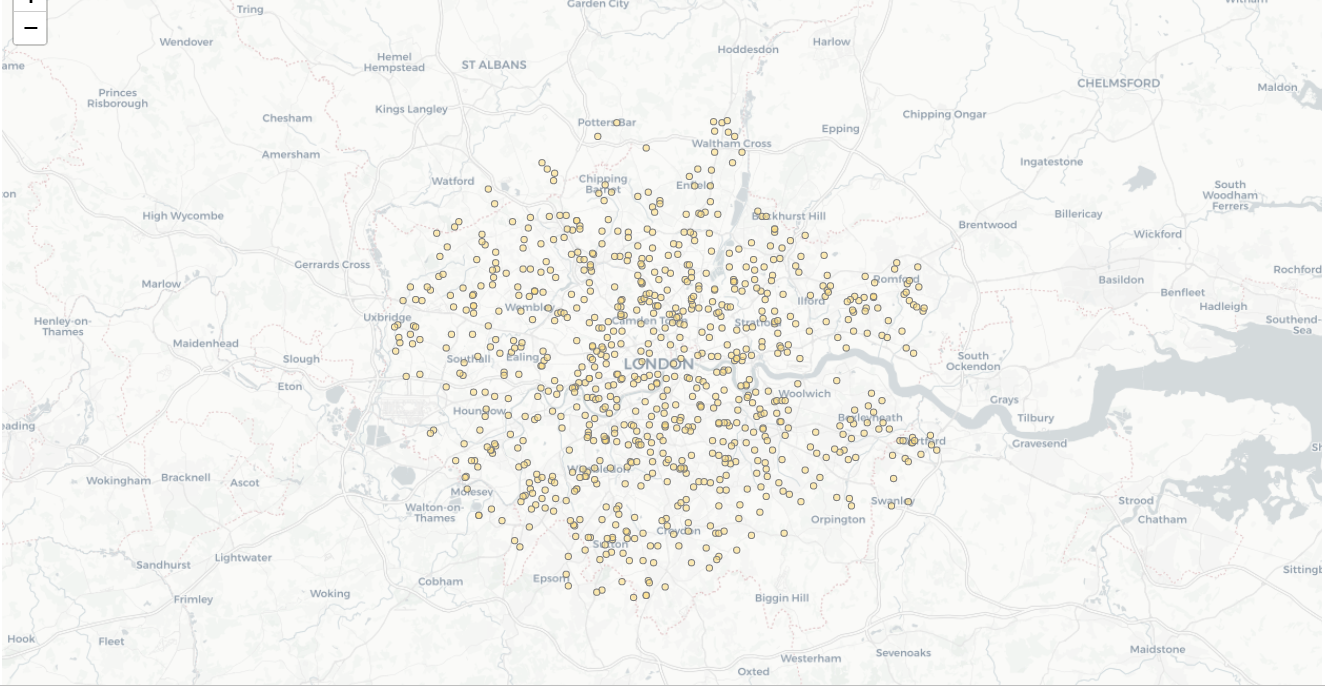

In [32]:
from PIL import Image as pimg
pimg.open('plot_london.png')

<h2> Part 4 - k-means Clustering </h2>

<p> To find a better k, two metrics are used, the inertia and Silhouette score. </p>

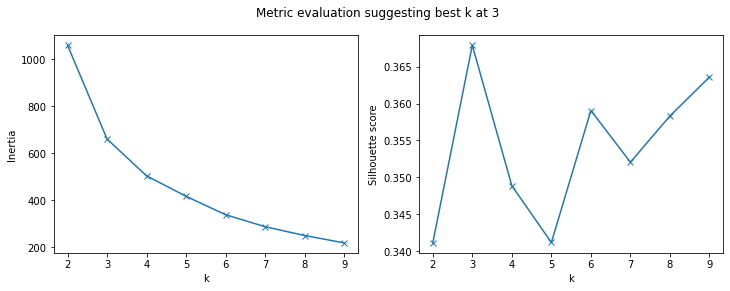

In [35]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

elbow = []
silh = []
cluster_data = df_select[['lat','lng']]
scal = StandardScaler()
cluster_trans = scal.fit_transform(cluster_data)

for i in range(2,10):
    k_means = KMeans(init="k-means++", n_clusters=i, n_init=12)
    k_means.fit(cluster_trans)
    elbow.append((i, k_means.inertia_))
    
    cluster_labels = k_means.fit(cluster_trans).labels_
    silh_avg = silhouette_score(cluster_trans, cluster_labels)
    silh.append((i, silh_avg))

elbow = list(zip(*elbow))
silh = list(zip(*silh))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

fig.suptitle('Metric evaluation suggesting best k at 3')
ax1.set(xlabel='k', ylabel='Inertia')
ax2.set(xlabel='k', ylabel='Silhouette score')
ax1.plot(elbow[0], elbow[1],'-x')
ax2.plot(silh[0], silh[1],'-x')

<p> It is found that the best k is at 3. Next is to computer the inverse transform of centroids to obtain the coordinates. </p>

In [36]:
best_k = 3
k_means = KMeans(init="k-means++", n_clusters=best_k, n_init=12)
cluster_labels = k_means.fit(cluster_trans).labels_
cluster_data['Region'] = cluster_labels
centroids = scal.inverse_transform(k_means.cluster_centers_)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [37]:
centroids

array([[ 5.15754357e+01, -2.25447896e-01],
       [ 5.15086269e+01,  4.67679910e-02],
       [ 5.14230804e+01, -1.87477272e-01]])

In [38]:
colors = ['#7FFFD4','#FFE082','#FF4a82','#69CCFF','#FFCCFF']
#colors = ['pink', 'lightgray', 'darkred', 'darkgreen', 'cadetblue', 'orange', 'darkblue', 'white', 'lightblue', 'lightgreen', 'red', 'black', 'yellow']
school_clus_map = folium.Map(location=[cen_lat, cen_lng], zoom_start=10, tiles="cartodbpositron") # generate map centred at Charing Cross

for i in range(best_k):
    clus = cluster_data[cluster_data['Region']==i]
    for lat, lng in zip(clus.lat, clus.lng):
        folium.CircleMarker(
            [lat, lng],
            radius=4,
            popup='Cluster '+str(i),
            color="grey",
            weight=1,
            fill=True,
            fill_color=colors[i],
            fill_opacity=0.7,
            ).add_to(school_clus_map)

    folium.Marker(
    [centroids[i][0], centroids[i][1]],
    icon=folium.Icon(color='gray',icon='fa-home', prefix='fa'),
    popup='Cluster {}, {}'.format(str(i),colors[i]),
    ).add_to(school_clus_map)
    
# display map
school_clus_map

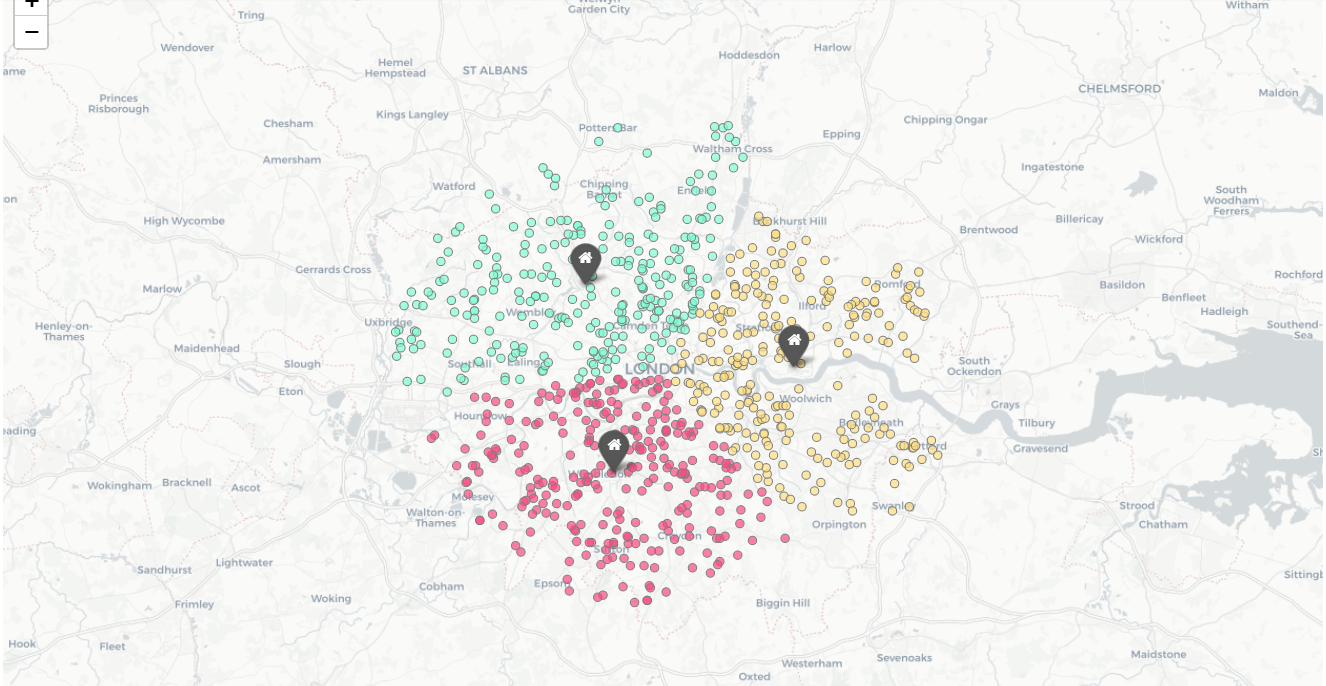

In [40]:
pimg.open('plot_clustered_schools.png')

<h2> Part 5 - Explore the neighbourhood of centroids </h2>

In [41]:
# Explore 50 premises within 2km of each centriod
limit = 50
radius = 2000
centroids

array([[ 5.15754357e+01, -2.25447896e-01],
       [ 5.15086269e+01,  4.67679910e-02],
       [ 5.14230804e+01, -1.87477272e-01]])

In [42]:
df_cen = []
i = 0
for lat, lng in centroids:
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, ACCESS_TOKEN, VERSION, radius, limit)
    try:
        results = requests.get(url).json()
        items = results['response']['groups'][0]['items']
    except:
        print('get centriod at ',lat,' ',lng,' failed')
        pass
    try:
        df_temp = pd.json_normalize(items)
        #df_temp['categories'] = df_temp['venue.categories'].apply(lambda x: x[0]['name'])
    except:
        pass
    
    df_temp['centroidlat'] = lat
    df_temp['centroidlng'] = lng
    df_temp['centroid'] = i
    i+=1
    df_cen.append(df_temp)

df_cen = pd.concat(df_cen, ignore_index=True)
df_cen['category'] = df_cen['venue.categories'].apply(lambda x: x[0]['name'])
df_cen.to_csv('centroids{}.csv'.format(best_k), index=False)

<p> Next is to pivot categories and centroids to see the distribution of various venues near a centroid. </p>

In [43]:
df_cen = pd.read_csv('centroids{}.csv'.format(best_k))
df_piv = df_cen[['centroid','category','venue.id']]
df_piv['category'].unique()

array(['Department Store', 'Park', 'Snack Place', 'Supermarket',
       'Portuguese Restaurant', 'Grocery Store', 'Lingerie Store', 'Café',
       'Furniture / Home Store', 'Sandwich Place', 'Korean Restaurant',
       'Hotel', 'Clothing Store', 'Pizza Place', 'Coffee Shop',
       'Donut Shop', 'Cupcake Shop', 'Shopping Mall',
       'Turkish Restaurant', 'Indian Restaurant', 'BBQ Joint',
       'Stationery Store', 'Sporting Goods Shop', 'Gastropub',
       'Electronics Store', 'Italian Restaurant', 'Falafel Restaurant',
       'Sushi Restaurant', 'Student Center', 'Chinese Restaurant',
       'Gym / Fitness Center', 'Indoor Play Area', 'Gym', 'Rafting',
       'Theater', 'Dam', 'Hotel Bar', 'Airport', 'Go Kart Track',
       'Tapas Restaurant', 'Discount Store', 'Scenic Lookout', 'Bridge',
       'Wine Bar', 'Art Gallery', 'Pub', 'Museum', 'Steakhouse',
       'Pharmacy', 'Airport Service', 'Restaurant', 'Noodle House',
       'Brewery', 'Burger Joint', 'Movie Theater', 'Brazilian Re

<p> To start with, the features of other clusters will be separated by 'food' and 'non-food', since it is quite expected that restaurants are more popular on Foursquare. </p>

In [45]:
food = 'Restaurant|Café|Coffee Shop|Pub|Bar|Pizza Place|Gastropub|Fish & Chips Shop|Sandwich Place|Steakhouse'

<p> Then to pivot category with centroid </p>

In [86]:
df_piv_food = df_cen[df_cen['category'].str.contains(food)][['centroid','category','venue.id']]
df_piv_food.pivot_table(index=['category'],columns=['centroid'], aggfunc='count',fill_value=0)
#df_piv_food[df_piv['centroid']==2]['category'].unique()

venue.id      
centroid                     0  1  2
category                            
Asian Restaurant             0  0  1
Bar                          0  0  1
Brazilian Restaurant         0  0  1
Café                         4  1  1
Chinese Restaurant           1  1  0
Coffee Shop                  4  5  4
Falafel Restaurant           1  0  0
Fast Food Restaurant         0  0  1
Fish & Chips Shop            0  0  1
Gastropub                    1  1  0
Hotel Bar                    0  2  0
Indian Restaurant            1  0  1
Italian Restaurant           1  1  3
Korean Restaurant            3  0  0
Lebanese Restaurant          0  0  3
Pizza Place                  1  0  0
Portuguese Restaurant        1  0  2
Pub                          0  2  8
Restaurant                   0  0  1
Sandwich Place               1  1  0
Sri Lankan Restaurant        0  0  1
Steakhouse                   0  1  1
Sushi Restaurant             2  0  3
Tapas Restaurant             0  1  1
Turkish Restaurant           1  0  0
Vietnamese Restaurant        0  0  1
Wine Bar                     0  1  0

<p> Let's also explore venues other than food premises. </p>

In [87]:
df_piv_non_food = df_cen[~df_cen['category'].str.contains(food)][['centroid','category','venue.id']]
df_piv_non_food.pivot_table(index=['category'],columns=['centroid'], aggfunc='count',fill_value=0).tail(20)
#df_piv_non_food[df_piv['centroid']==2]['category'].unique().shape

venue.id       
centroid                    0   1  2
category                            
Gym                         1   0  0
Gym / Fitness Center        1   3  2
Hotel                       1  11  1
Indoor Play Area            1   0  0
Lingerie Store              1   0  0
Liquor Store                0   0  1
Movie Theater               0   0  1
Museum                      0   1  0
Noodle House                0   0  1
Park                        3   2  3
Pharmacy                    0   1  0
Rafting                     0   1  0
Scenic Lookout              0   1  0
Shopping Mall               1   0  0
Snack Place                 1   0  0
Sporting Goods Shop         1   0  0
Stationery Store            1   0  0
Student Center              1   0  0
Supermarket                 1   2  0
Theater                     0   1  1

<p> To be more explicit: </p>

In [88]:
for i in range(len(centroids)):
    clus_list = df_cen[(df_cen['centroid']==i) & (~df_cen['category'].str.contains(food))]['category'].unique()
    print('Cluster',i, tuple(centroids[i]), 'also has')
    print(clus_list,'\n')

Cluster 0 (51.57543565471447, -0.22544789562464) also has
['Department Store' 'Park' 'Snack Place' 'Supermarket' 'Grocery Store'
 'Lingerie Store' 'Furniture / Home Store' 'Hotel' 'Clothing Store'
 'Donut Shop' 'Cupcake Shop' 'Shopping Mall' 'BBQ Joint'
 'Stationery Store' 'Sporting Goods Shop' 'Electronics Store'
 'Student Center' 'Gym / Fitness Center' 'Indoor Play Area' 'Gym'] 

Cluster 1 (51.50862693766204, 0.04676799102577994) also has
['Hotel' 'Rafting' 'Park' 'Theater' 'Dam' 'Gym / Fitness Center'
 'Supermarket' 'Airport' 'Go Kart Track' 'Discount Store' 'Scenic Lookout'
 'Bridge' 'Grocery Store' 'Art Gallery' 'Museum' 'Pharmacy'
 'Airport Service'] 

Cluster 2 (51.423080412701154, -0.18747727156209634) also has
['Noodle House' 'Park' 'Theater' 'Brewery' 'Burger Joint' 'Movie Theater'
 'Liquor Store' 'Flea Market' 'Gym / Fitness Center' 'Hotel' 'Beer Store'
 'Dessert Shop'] 



<h2> 6. Recommendation </h2>

<p> Based on the above results, the clustering gives 3 distinct regions. Cluster 0 (green) at Northwestern part of London, cluster 1 (yellow) at Eastern part, and cluster 2 (red) at Southern part. </p>

<p> It can be seen that <strong>cluster 2 </strong> has the <strong> most unique types of food premises (18)</strong> compared to clusters 0 (13) and 1 (11). On the other hand, <strong> cluster 0 </strong> has the <strong> most unique tyes of non-food premises (20)</strong> compared to cluster 1 (17) and 2 (12). </p>

<p> Take a closer look at cluster 0, the varieties are quite good for living, for example, there are clothing stores, department stores, grocery, supermarket. These are seldom seen in cluster 1 and 2. </p>

<p> For cluster 1, it is remarked by an airport and a lots of hotels. </p>

<p> At cluster 2, there are indeed tons of restaurants and theatres. Good for entertainment. </p>
    
<p> So for a family with kids, with easy access to schools, London is clustered into 3 regions. <strong>The family may wish to settle at cluster 0</strong> (centroid coordinates 51.5754, -0.2254). It turns out that it is at <strong> Brent Cross </strong>, which there is a <a href='https://en.wikipedia.org/wiki/Brent_Cross_Shopping_Centre'>large shopping centre</a>. No doubt the numbers of stores are found by Foursquare there. </p>

<h2> This is the end of this notebook. Thank you. </h2>